In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glhmm.glhmm as glhmm
import seaborn as sns
import network_tools as nt
import importlib
import networkx as nx
import dynamics as dyn
from scipy.linalg import eig
import csv
from sklearn.cluster import KMeans,MiniBatchKMeans
import statespacesplitting as sss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import hmm_helper as hmmh

/tmp/ipykernel_747674/1503008179.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [51]:
importlib.reload(nt)
importlib.reload(dyn)
importlib.reload(sss)
importlib.reload(hmmh)

<module 'hmm_helper' from '/home/nartallokalu/Desktop/hmm/hmm_helper.py'>

In [3]:
N = 3
W = nt.generate_hierarchical_network(N,mu = 0.2,p0 = 1,recip = 10)

In [4]:
Theta = 1
gamma = 0.1
sigma = 0.05
dt = 0.05
steps = 1000
print(np.real(np.linalg.eig(Theta*(np.diag(np.ones(N))-gamma*W)).eigenvalues)>0)
Phi = dyn.EPR_network_ornstein_uhlenbeck(W,sigma,Theta,gamma)

[ True  True  True]


In [5]:
[X,t] = dyn.network_ornstein_uhlenbeck(nt.parameterise_network(W,1),sigma,Theta,gamma,dt,steps)
tau = 20
X_sampled = X[:,0::tau]
t_sampled= t[0::tau]

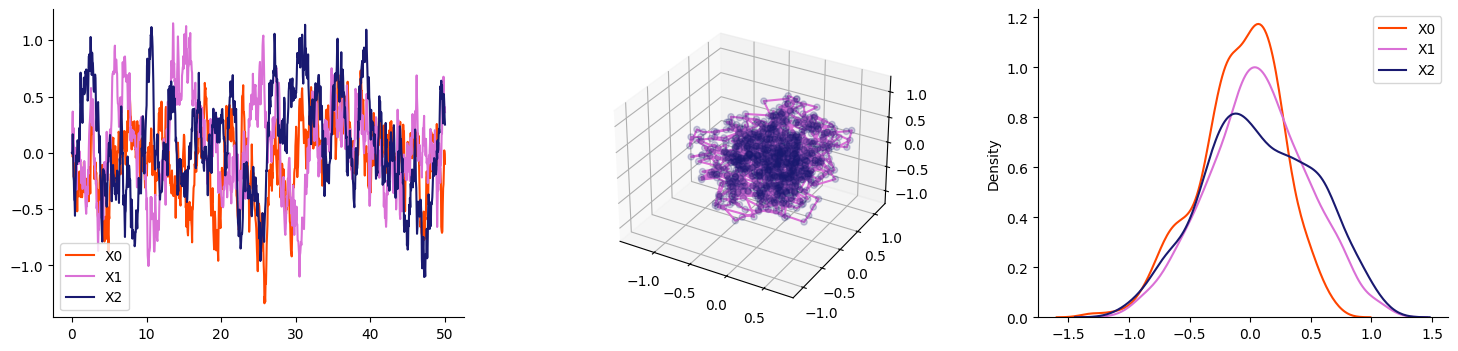

<Figure size 640x480 with 0 Axes>

In [17]:
fig = plt.figure()
axs=[0,0,0]
axs[0] = fig.add_subplot(1,3,1)
axs[1] = fig.add_subplot(1,3,2,projection='3d')
axs[2] = fig.add_subplot(1,3,3)
fig.set_size_inches(18,4)
cols = ['orangered','orchid','midnightblue']
for i in range(0,3):
    sns.lineplot(x=t,y=X[i,:],label = 'X'+str(i),ax=axs[0],color=cols[i])
    sns.despine()
    sns.kdeplot(X[i,:],label='X'+str(i),color=cols[i],ax=axs[2])
axs[1].plot(X[0,:], X[1,:], X[2,:], color = 'orchid')
axs[1].scatter(X[0,:], X[1,:], X[2,:], color = 'midnightblue',alpha=0.2)
axs[2].legend()
plt.show()
sns.despine()
plt.tight_layout()
plt.show()

/tmp/ipykernel_747674/528250396.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


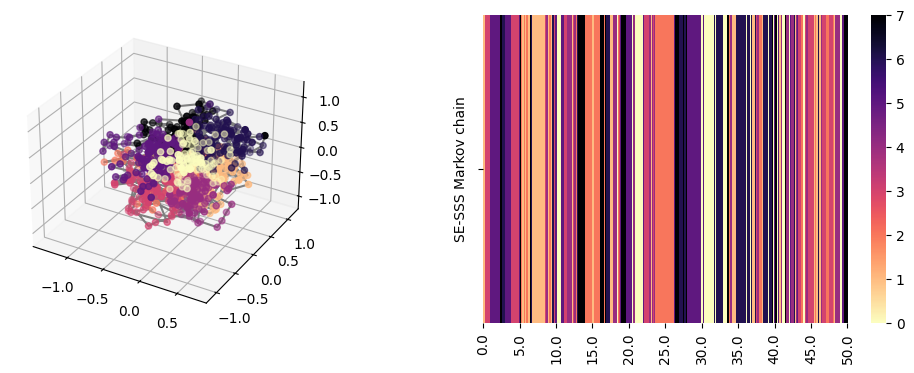

In [64]:
box_tc, box_idx_tc = sss.state_space_split(X,3,sss.boundary_list_stat_even(X,[2,2,2]))
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black']
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('SE-SSS Markov chain')
plt.show()
SE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

/tmp/ipykernel_747674/2142964681.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


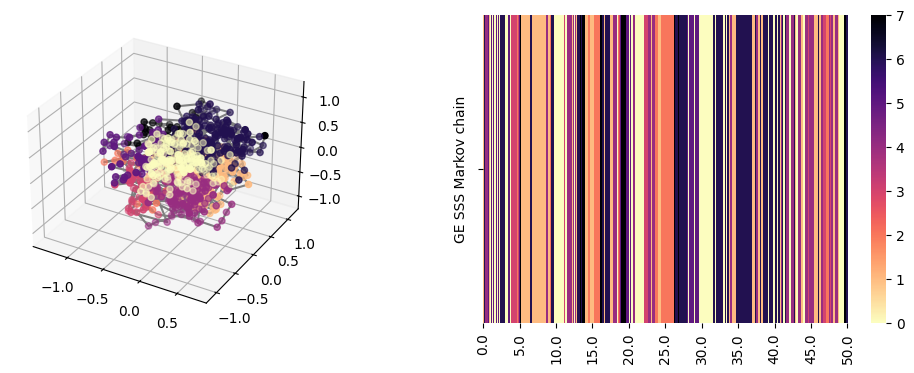

In [65]:
box_tc, box_idx_tc = sss.state_space_split(X,3,sss.boundary_list_geom_even(X,[2,2,2]))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('GE SSS Markov chain')
plt.show()
GE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

In [66]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X),viterbi=True))

Init repetition 1 free energy = 1417.3287642241908
Init repetition 2 free energy = 1535.0686022934133
Init repetition 3 free energy = 1488.0497072328458
Init repetition 4 free energy = 1489.0305308531329
Init repetition 5 free energy = 1437.4804734092295
Best repetition: 1
Cycle 1 free energy = 1566.5385207649567
Cycle 2 free energy = 1414.7102689090943
Cycle 3, free energy = 1413.0302331763237, relative change = 0.01094426730413903
Cycle 4, free energy = 1411.8928061522092, relative change = 0.007355050393492767
Cycle 5, free energy = 1410.6918988535767, relative change = 0.007705699898425646
Cycle 6, free energy = 1408.8880644092708, relative change = 0.011441986823280705
Cycle 7, free energy = 1407.4316447884212, relative change = 0.009153718919504072
Cycle 8, free energy = 1406.5908695294304, relative change = 0.005256565210530845
Cycle 9, free energy = 1406.0252958203325, relative change = 0.003523533399151256
Cycle 10, free energy = 1405.626272767971, relative change = 0.00247975

/tmp/ipykernel_747674/3151467013.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


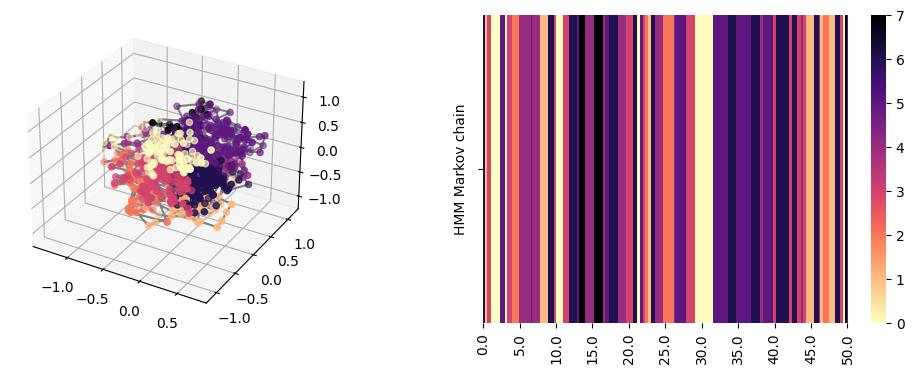

In [67]:
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM Markov chain')
plt.show()

In [68]:
kmeans = KMeans(n_clusters = 8).fit(np.transpose(X))
kmeans.labels_

array([0, 0, 2, ..., 5, 2, 2], dtype=int32)

/tmp/ipykernel_747674/962611857.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


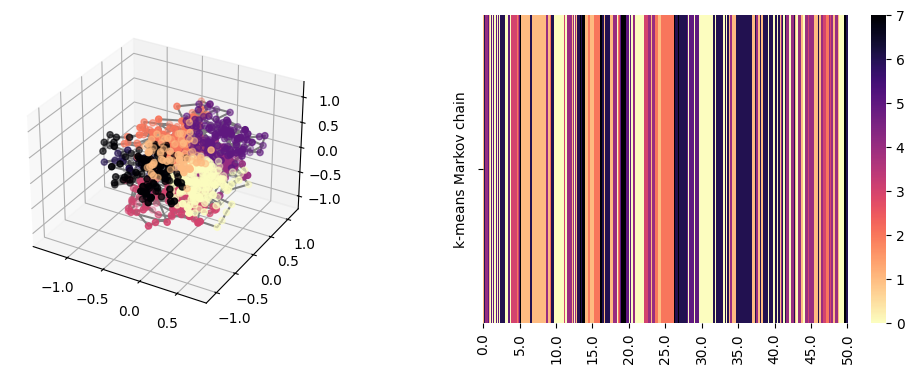

In [69]:
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(kmeans.labels_)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('k-means Markov chain')
plt.show()

In [70]:
K_means_TP = dyn.markov_chain_to_TP(kmeans.labels_,8)
HMM_TP = hmm.P

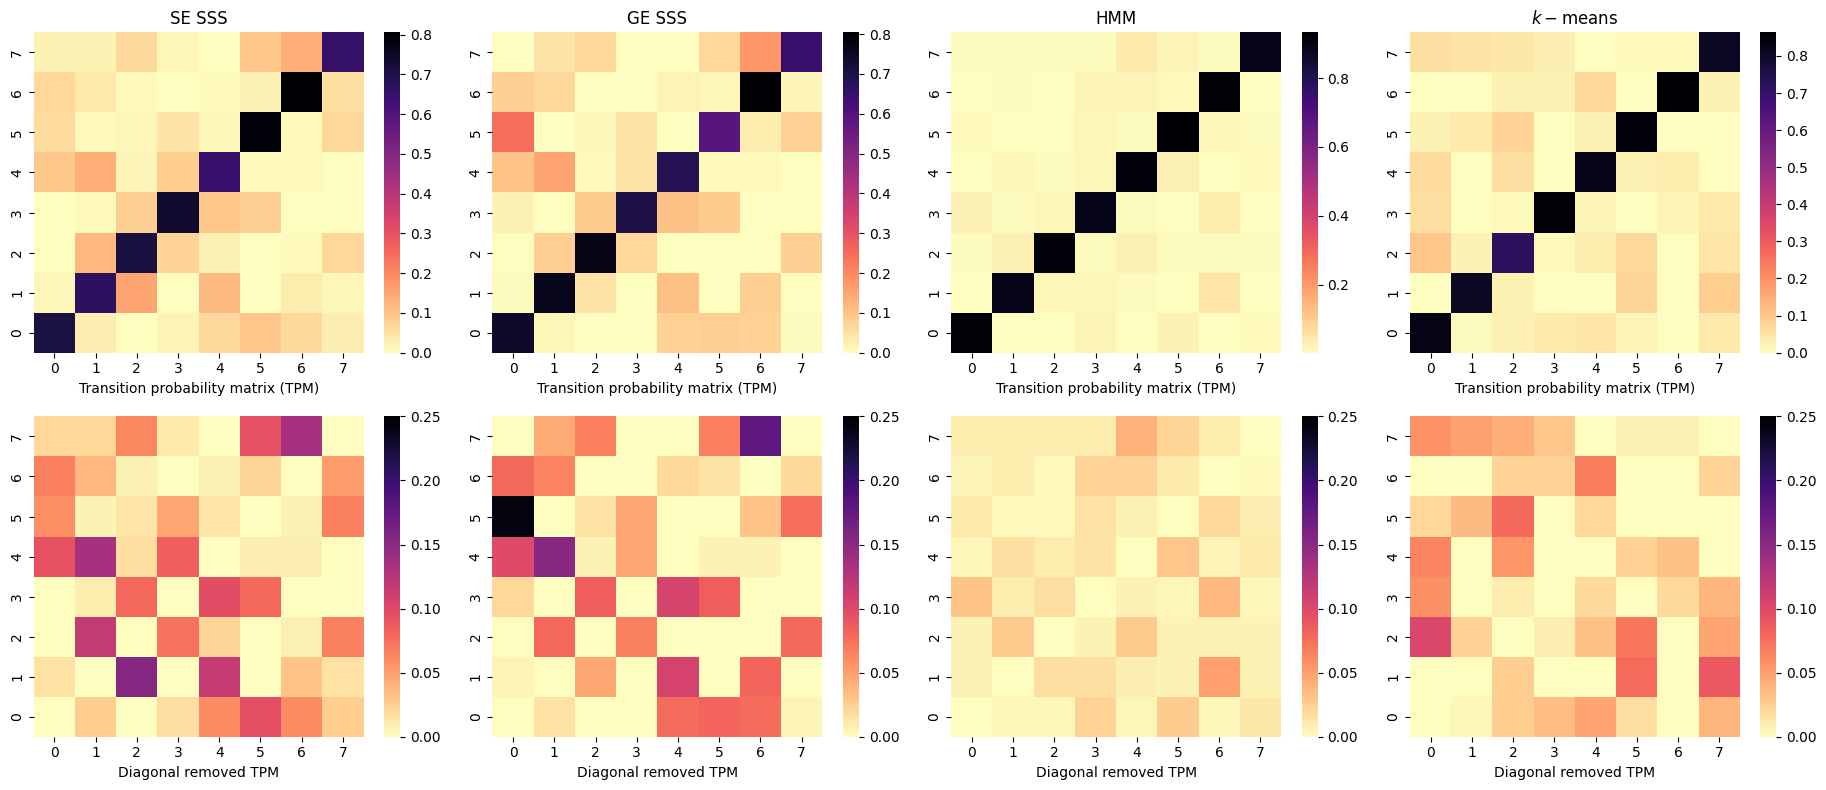

In [105]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18.5,8)
sns.heatmap(SE_SSS_TP,ax=axs[0,0],cmap='magma_r')
axs[0,0].invert_yaxis()
sns.heatmap(GE_SSS_TP,ax=axs[0,1],cmap='magma_r')
axs[0,1].invert_yaxis()
sns.heatmap(HMM_TP,ax=axs[0,2],cmap='magma_r')
axs[0,2].invert_yaxis()
sns.heatmap(K_means_TP,ax=axs[0,3],cmap='magma_r')
axs[0,3].invert_yaxis()
sns.heatmap(SE_SSS_TP-np.diag(np.diag(SE_SSS_TP)),ax=axs[1,0],cmap='magma_r',vmin = 0,vmax = 0.25)
axs[1,0].invert_yaxis()
sns.heatmap(GE_SSS_TP-np.diag(np.diag(GE_SSS_TP)),ax=axs[1,1],cmap='magma_r',vmin = 0,vmax = 0.25)
axs[1,1].invert_yaxis()
sns.heatmap(HMM_TP-np.diag(np.diag(HMM_TP)),ax=axs[1,2],cmap='magma_r',vmin = 0,vmax = 0.25)
axs[1,2].invert_yaxis()
sns.heatmap(K_means_TP-np.diag(np.diag(K_means_TP)),ax=axs[1,3],cmap='magma_r',vmin = 0,vmax = 0.25)
axs[1,3].invert_yaxis()
axs[0,0].set_title('SE SSS')
axs[0,1].set_title('GE SSS')
axs[0,2].set_title('HMM')
axs[0,3].set_title(r'$k-$' + 'means')
for i in range(0,4):
    axs[0,i].set_xlabel('Transition probability matrix (TPM)')
for i in range(0,4):
    axs[1,i].set_xlabel('Diagonal removed TPM')
plt.tight_layout()
plt.show()